**IMP: Example here is not so convincing refer here**

https://github.com/subhamkharwal/pyspark-zero-to-hero/blob/master/20_skewness_and_spillage.ipynb

https://www.youtube.com/watch?v=2oaTQl1YzCw&list=PL2IsFZBGM_IHCl9zhRVC1EXTomkEp_1zm&index=24

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, udf, rand
from pyspark.sql.types import IntegerType
import random

# Initialize Spark session
spark = SparkSession.builder.master("local[2]").appName("Salting Disproportionate Orders II").getOrCreate()

# Disable AQE and Broadcast join
spark.conf.set("spark.sql.adaptive.enabled", False)
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", False)
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

# Define constants for the large dataset
num_customers = 10000  # 10,000 customers
num_products = 500  # 500 products
num_orders = 1000000  # 1 million orders

# Step 1: Create Customers DataFrame
customers_data = [(i, f"Customer_{i}", random.choice(["NYC", "LA", "Chicago", "SF"])) for i in range(1, num_customers+1)]
customers = spark.createDataFrame(customers_data, ["customer_id", "name", "city"])

# Step 2: Create Products DataFrame
products_data = [(i, f"Product_{i}", random.choice(["Electronics", "Apparel", "Books"])) for i in range(1, num_products+1)]
products = spark.createDataFrame(products_data, ["product_id", "product_name", "category"])

# Step 3: Generate Exactly 1 Million Orders with Stronger Skewed Distribution

# Initialize total orders counter and list for orders
orders_data = []
current_orders = 0

# Number of top customers who will place disproportionate orders (Top 5%)
top_customers = random.sample(range(1, num_customers+1), int(num_customers * 0.05))  # Top 5% customers

# Distribute orders among customers
while current_orders < num_orders:
    # For each customer
    for customer_id in range(1, num_customers+1):
        if current_orders >= num_orders:
            break
        
        # Top customers get 100 orders each (much higher skew)
        if customer_id in top_customers:
            num_orders_per_customer = 100
        else:
            # Other customers get 0 or 1 order
            num_orders_per_customer = random.choice([0, 1])

        # Generate orders for this customer
        for _ in range(num_orders_per_customer):
            if current_orders >= num_orders:
                break
            product_id = random.choice(range(1, num_products+1))
            amount = random.uniform(10.0, 500.0)  # Random order amount
            orders_data.append((len(orders_data)+1, customer_id, product_id, amount))
            current_orders += 1

# Check the total number of orders generated
print(f"Total Orders Generated: {current_orders}")

# Create the Orders DataFrame
orders = spark.createDataFrame(orders_data, ["order_id", "customer_id", "product_id", "amount"])

# Step 4: Perform a Join with Customers to add customer information to the orders DataFrame
joined_df_new = orders.join(customers, "customer_id", "inner")

# Show some of the generated orders after the join
joined_df_new.show(10, truncate=False)


Total Orders Generated: 1000000


25/02/26 16:46:00 WARN TaskSetManager: Stage 115 contains a task of very large size (10856 KiB). The maximum recommended task size is 1000 KiB.
[Stage 115:>                                                        (0 + 2) / 2]

+-----------+--------+----------+------------------+-----------+-------+
|customer_id|order_id|product_id|amount            |name       |city   |
+-----------+--------+----------+------------------+-----------+-------+
|26         |112     |279       |14.029797807869079|Customer_26|Chicago|
|26         |54855   |102       |314.2799345616443 |Customer_26|Chicago|
|26         |109629  |153       |179.16771770908352|Customer_26|Chicago|
|26         |164308  |414       |428.5181392065412 |Customer_26|Chicago|
|26         |383297  |218       |300.61458717238645|Customer_26|Chicago|
|26         |492784  |158       |165.0779683858354 |Customer_26|Chicago|
|26         |547651  |33        |382.9406918371106 |Customer_26|Chicago|
|26         |711932  |141       |47.92211387173763 |Customer_26|Chicago|
|26         |875989  |294       |287.53691111898837|Customer_26|Chicago|
|26         |985481  |269       |253.7166090002945 |Customer_26|Chicago|
+-----------+--------+----------+------------------

In [18]:
joined_data_new.count()

25/02/26 16:46:12 WARN TaskSetManager: Stage 117 contains a task of very large size (10855 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

1000000

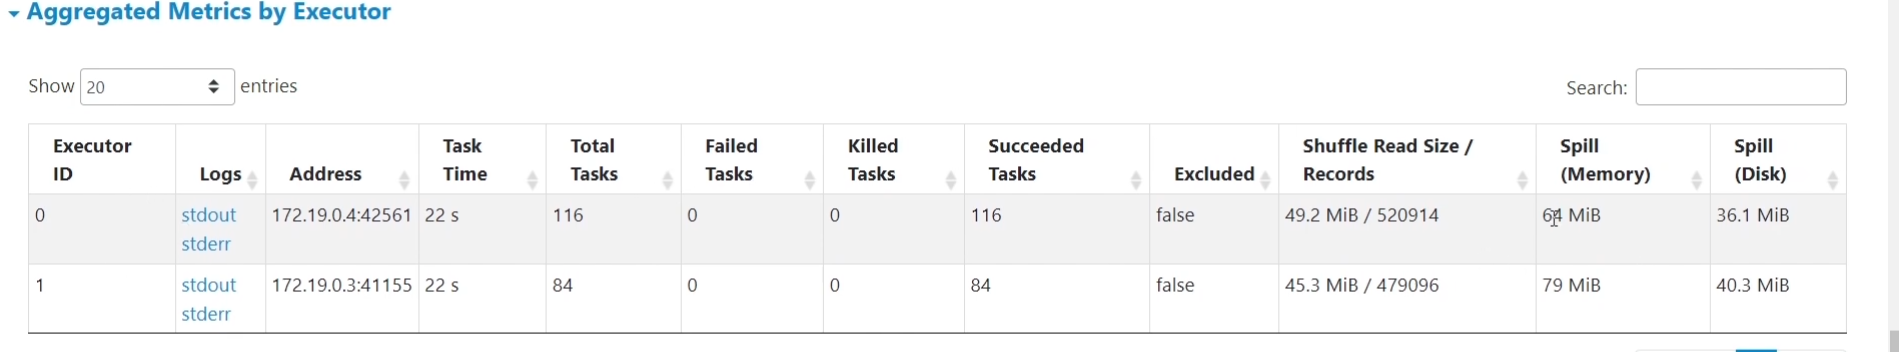

In [19]:
joined_data_new.explain()

== Physical Plan ==
*(9) Project [product_id#14L, customer_id#13L, order_id#12L, amount#15, name#1, city#2, product_name#7, category#8]
+- *(9) SortMergeJoin [product_id#14L], [product_id#6L], LeftOuter
   :- *(6) Sort [product_id#14L ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(product_id#14L, 200), ENSURE_REQUIREMENTS, [plan_id=1427]
   :     +- *(5) Project [customer_id#13L, order_id#12L, product_id#14L, amount#15, name#1, city#2]
   :        +- *(5) SortMergeJoin [customer_id#13L], [customer_id#0L], LeftOuter
   :           :- *(2) Sort [customer_id#13L ASC NULLS FIRST], false, 0
   :           :  +- Exchange hashpartitioning(customer_id#13L, 200), ENSURE_REQUIREMENTS, [plan_id=1413]
   :           :     +- *(1) Scan ExistingRDD[order_id#12L,customer_id#13L,product_id#14L,amount#15]
   :           +- *(4) Sort [customer_id#0L ASC NULLS FIRST], false, 0
   :              +- Exchange hashpartitioning(customer_id#0L, 200), ENSURE_REQUIREMENTS, [plan_id=1419]
   :     

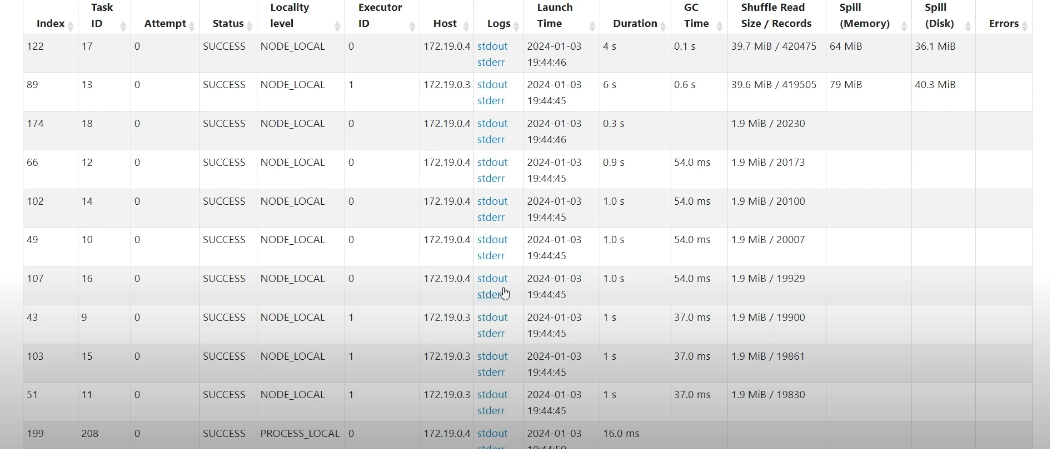

Out of 200, only a handful of partitions actually read data the rest do not

First two process large amount of data compared to the others

### Spilled to Disk Vs Spilled to Memory

**Spilled to Memory:**
   
Definition: This occurs when Spark stores intermediate data (like shuffle files, sorting, etc.) in RAM (memory). When Spark needs to store large amounts of data for operations like shuffling, sorting, or aggregating, it will first attempt to use memory.

When does it happen?: This happens when there is sufficient memory available in the executor's heap. Spark will attempt to use in-memory storage because it’s faster compared to disk.

**Advantages:**

Faster performance: Accessing data from memory is much faster than accessing from disk.

Lower Latency: There is very little delay because no I/O operations to the disk are required.

**Disadvantages:**

Memory Consumption: It can be memory-intensive. If your data exceeds the available memory, Spark might spill to disk anyway.

GC Overhead: Storing large amounts of data in memory can put pressure on the JVM garbage collector, leading to possible performance bottlenecks.

Configuration: You can configure Spark to handle memory usage using properties such as spark.memory.fraction (which defines how much memory Spark can use for execution and storage) and spark.memory.storageFraction (which defines the fraction of memory used for storage).

**Spilled to Disk:**

Definition: This occurs when Spark moves the data from memory to disk in the event of insufficient memory. If Spark is running out of memory to store intermediate results (such as during shuffling or sorting), it will spill the data to disk to prevent out-of-memory errors.

When does it happen?: 

It happens when:

The amount of data being processed exceeds the available memory.
The data exceeds the configured memory limits, causing Spark to spill to disk.
When Spark is performing shuffle operations, if not enough memory is available, it writes data to temporary files on disk.

Advantages:

Prevents out-of-memory errors: Spilling to disk helps avoid memory overflow or OOM (Out of Memory) errors.
Larger datasets: Even if the data exceeds available memory, Spark can still process it by spilling to disk.

Disadvantages:

Slower Performance: Disk I/O is much slower than accessing memory, leading to increased latency and overall execution time.
Disk Pressure: Spilling to disk may cause the disk to become a bottleneck, particularly if the disk is slow or if there is insufficient disk space.

Disk Space Consumption: Spark may create a large number of temporary files, and if there is insufficient disk space, the job might fail.

Configuration: You can control spilling to disk using settings such as:

**spark.shuffle.spill** – This controls whether spilling is allowed during shuffle operations.

**spark.storage.memoryFraction** – Determines the fraction of heap space allocated for memory storage.

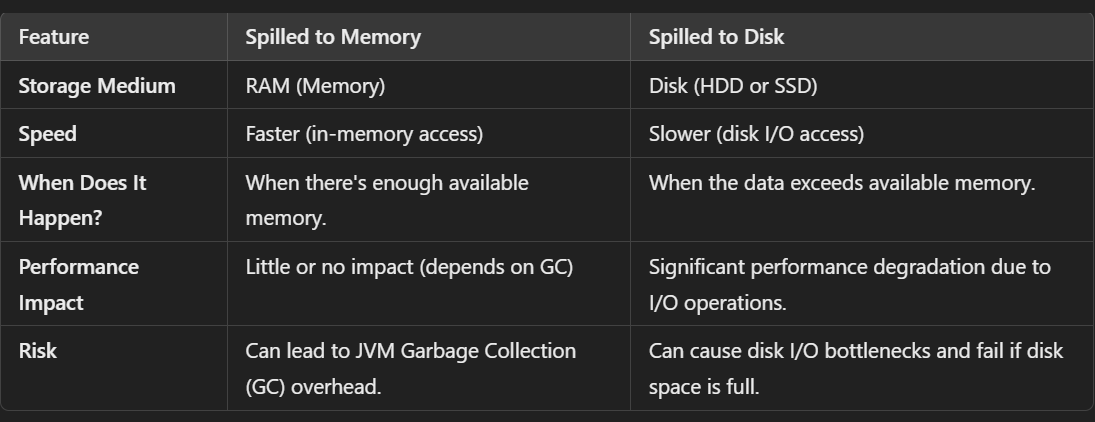

In [22]:
from pyspark.sql.functions import spark_partition_id,lit,count

part_df_new = joined_data_new.withColumn("part_num",spark_partition_id()).groupBy("part_num").agg(count(lit(1))).alias("count")

part_df_1000 = part_df_new.limit(1000)

In [23]:
part_df_1000.show()

25/02/26 16:47:33 WARN TaskSetManager: Stage 141 contains a task of very large size (10855 KiB). The maximum recommended task size is 1000 KiB.
[Stage 145:==============================================>      (174 + 2) / 200]

+--------+--------+
|part_num|count(1)|
+--------+--------+
|      31|    8036|
|      85|    1969|
|     137|    8016|
|      65|    5980|
|      53|    6013|
|     133|    2044|
|      78|    1950|
|     108|    7911|
|      34|    2018|
|     193|    4018|
|     101|    1983|
|     115|   10005|
|     126|    8139|
|      81|    5997|
|      28|    4044|
|     183|    2023|
|      76|    3965|
|      26|    4016|
|      27|    2016|
|      44|    8033|
+--------+--------+
only showing top 20 rows

